<a href="https://colab.research.google.com/github/adampotton/Cognitive_AI_CW/blob/main/Q2D_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contrast  attention

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import time
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Define Model with Contrast Attention Layers

In [11]:
img_size_div4 = 45

class ContrastAttentionLayer(nn.Module):
    def __init__(self, in_channels):
        super(ContrastAttentionLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Compute gradient (difference between adjacent pixels)
        grad_x = x[:, :, :, 1:] - x[:, :, :, :-1]  # Difference along x-axis
        grad_y = x[:, :, 1:, :] - x[:, :, :-1, :]  # Difference along y-axis

        # Pad gradients to the original image size (match height and width)
        grad_x = F.pad(grad_x, (0, 1, 0, 0), mode='constant', value=0)  # Pad x-axis
        grad_y = F.pad(grad_y, (0, 0, 0, 1), mode='constant', value=0)  # Pad y-axis

        # Combine gradients to get contrast map
        contrast_map = torch.abs(grad_x) + torch.abs(grad_y)  # Absolute sum of gradients

        # Normalize contrast map
        contrast_map = F.interpolate(contrast_map, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=True)
        contrast_map = torch.sigmoid(contrast_map)  # Apply sigmoid to normalize the attention weights

        return contrast_map

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(16 * 45 * 45, 128)  # Adjust size according to your image size
        self.fc2 = nn.Linear(128, 3)
        self.attn1 = ContrastAttentionLayer(8)

    def forward(self, x):
        attn1_weights = self.attn1(x)
        x = x * attn1_weights
        x = self.pool(torch.relu(self.conv1(x))) # Compute attention for first layer
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 16 * 45 * 45)  # Flatten for fully connected layer
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x, attn1_weights


### Load and Edit Data

In [9]:
img_size = img_size_div4 * 4 # Define image size

train_transform = transforms.Compose([ # Define transformations for training
    transforms.Resize((img_size, img_size)),  # Resize images to the desired size
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=4),   # Randomly rotate images by up to 15 degrees
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transform = transforms.Compose([ # Define transformations for testing (no augmentation)
    transforms.Resize((img_size, img_size)),  # Resize images to the desired size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Define paths to your train and test directories
train_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/train'
test_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/test'

batch_size = 20
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform) # Load datasets using ImageFolder
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Create DataLoader for batching
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Train the Model

In [12]:
lr = 0.0006 # Learning rate
num_epochs = 20 # Number of epochs for training

model = CNN() # Initialise a model
criterion = nn.CrossEntropyLoss()  # Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
t = time.time() # Start timer
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader: # Loop through images and labels to train
        optimizer.zero_grad()
        output,_ = model(images)
        loss = criterion(output, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    time_elapsed = time.time() - t # Calculate time elapsed
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Time: {time_elapsed}")


Epoch 1/20, Loss: 1.1309, Accuracy: 0.3572, Time: 17.178086280822754
Epoch 2/20, Loss: 1.0436, Accuracy: 0.4768, Time: 32.525333881378174
Epoch 3/20, Loss: 0.9702, Accuracy: 0.5288, Time: 50.62659430503845
Epoch 4/20, Loss: 0.8551, Accuracy: 0.6104, Time: 66.96953392028809
Epoch 5/20, Loss: 0.7936, Accuracy: 0.6779, Time: 83.20074772834778
Epoch 6/20, Loss: 0.7337, Accuracy: 0.6779, Time: 98.90482831001282
Epoch 7/20, Loss: 0.6800, Accuracy: 0.7286, Time: 114.87503480911255
Epoch 8/20, Loss: 0.6023, Accuracy: 0.7525, Time: 130.6219494342804
Epoch 9/20, Loss: 0.5179, Accuracy: 0.7947, Time: 146.471613407135
Epoch 10/20, Loss: 0.5203, Accuracy: 0.7848, Time: 162.2879147529602
Epoch 11/20, Loss: 0.4743, Accuracy: 0.8214, Time: 178.54447174072266
Epoch 12/20, Loss: 0.4516, Accuracy: 0.8340, Time: 195.43327069282532
Epoch 13/20, Loss: 0.3789, Accuracy: 0.8579, Time: 211.5719199180603
Epoch 14/20, Loss: 0.3701, Accuracy: 0.8622, Time: 227.4739224910736
Epoch 15/20, Loss: 0.3891, Accuracy: 0.

### Testing the Model

In [13]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in test_loader:
        output,_ = model(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5526


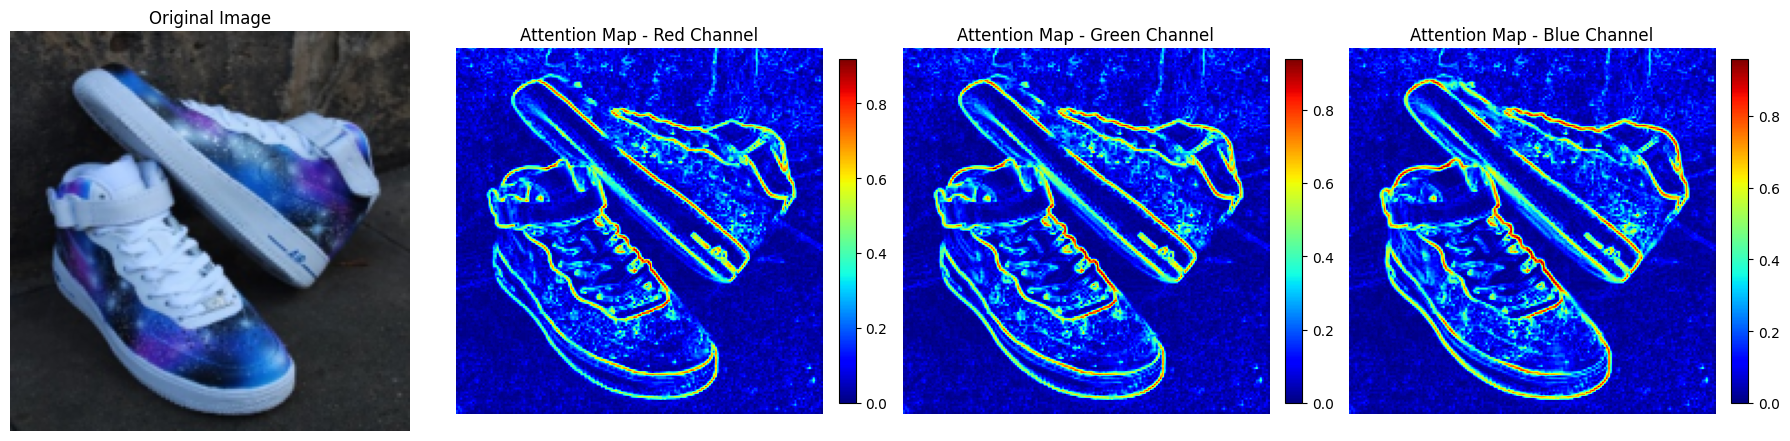

In [44]:
def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    return img * std + mean

model.eval()

data_iter = iter(test_loader)
random_batch = random.choice([batch for batch in data_iter])
image, label = random_batch

with torch.no_grad(): # Get the output and attention maps
    output, attn1_weights = model(image)

attn1_weights = attn1_weights.squeeze().cpu().numpy()  # Remove batch dimension
attn1_weights = (attn1_weights - attn1_weights.min()) / (attn1_weights.max() - attn1_weights.min())
r_attn = attn1_weights[:,0,:,:]
g_attn = attn1_weights[:,1,:,:]
b_attn = attn1_weights[:,2,:,:]

n = 8
# Convert the image to numpy (H, W, C) format for visualising
image = image[n].unsqueeze(0)
original_image = denormalize(image.clone(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
original_image = original_image.squeeze().permute(1, 2, 0).cpu().detach().numpy()
original_image = np.clip(original_image, 0, 1)

fig, ax = plt.subplots(1, 4, figsize=(18, 5))

# Original image
ax[0].imshow(original_image)
ax[0].set_title("Original Image")
ax[0].axis('off')

# Attention map for Red channel
ax1 = ax[1].imshow(r_attn[n], cmap='jet')
ax[1].set_title("Attention Map - Red Channel")
ax[1].axis('off')

# Attention map for Green channel
ax2 = ax[2].imshow(g_attn[n], cmap='jet')
ax[2].set_title("Attention Map - Green Channel")
ax[2].axis('off')

# Attention map for Blue channel
ax3 = ax[3].imshow(b_attn[n], cmap='jet')
ax[3].set_title("Attention Map - Blue Channel")
ax[3].axis('off')

fig.colorbar(ax1, ax=ax[1], fraction=0.043, pad=0.04)
fig.colorbar(ax2, ax=ax[2], fraction=0.043, pad=0.04)
fig.colorbar(ax3, ax=ax[3], fraction=0.043, pad=0.04)

plt.tight_layout()
plt.show()
